## 数据清洗

In [21]:
#先导入需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
#读取数据
df = pd.read_csv('./data/sh600132.csv')
 
#查看描述统计
df.describe().style.background_gradient(cmap = 'Oranges')

,open,high,low,close,old_close,volume,amount,active_value,total_value
count,6427.000000,6427.000000,6427.000000,6427.000000,6427.000000,6427.000000,6427.000000,6427.000000,6427.000000
mean,37.248133,38.071561,36.500476,37.308433,37.293123,3937029.426638,155839979.093823,15012504542.588766,16271645986.629221
std,36.207685,37.078078,35.390398,36.254985,36.254894,5743958.925658,228945773.517893,19246225075.687866,18523934902.380840
min,6.490000,6.890000,6.450000,6.550000,5.540000,9800.000000,116644.000000,324000000.000000,1413000000.000000
25%,15.700000,15.940000,15.490000,15.720000,15.715000,923722.000000,13165877.500000,1078220000.000000,3609671000.000000
50%,21.500000,21.900000,21.040000,21.560000,21.560000,2728464.000000,74908041.000000,7632225792.000000,8798596380.000000
75%,43.580000,44.750000,42.550000,43.760000,43.675000,4689830.000000,198805554.000000,20278393196.000000,20278393196.000000
max,204.000000,209.990000,201.020000,205.030000,205.030000,93487135.000000,2992033108.000000,99228614726.000000,99228614726.000000


## 添加股票指标

#### MADC

In [22]:
# 计算12日EMA和26日EMA
df["EMA12"] = df["close"].ewm(span=12, adjust=False).mean()
df["EMA26"] = df["close"].ewm(span=26, adjust=False).mean()

# 计算 DIF（快线）
df["DIF"] = df["EMA12"] - df["EMA26"]

# 计算 DEA（慢线），即 DIF 的 9 日 EMA
df["DEA"] = df["DIF"].ewm(span=9, adjust=False).mean()

# 计算 MACD 直方图
df["MACD"] = 2 * (df["DIF"] - df["DEA"])

# 删除中间计算过程中的列，只保留 MACD 列
df = df.drop(columns=["EMA12", "EMA26", "DIF", "DEA"])

# 显示结果
print(df[["date", "close", "MACD"]].head())

         date  close      MACD
0  1997/10/30  12.12  0.000000
1  1997/10/31  11.32 -0.102108
2   1997/11/3  10.95 -0.207747
3   1997/11/4  11.12 -0.240665
4   1997/11/5  10.88 -0.278059


#### RSI

In [23]:
# 计算每日涨跌
df["delta"] = df["close"].diff()

# 计算涨跌幅 (up / down)
df["up"] = df["delta"].apply(lambda x: x if x > 0 else 0)
df["down"] = df["delta"].apply(lambda x: -x if x < 0 else 0)

# 计算 6 日平均涨跌幅
df["avg_up"] = df["up"].rolling(window=6).mean()
df["avg_down"] = df["down"].rolling(window=6).mean()

# 避免除零错误
df["R6"] = df["avg_up"] / df["avg_down"].replace(0, 1)

# 计算 RSI6
df["RSI6"] = 100 - (100 / (1 + df["R6"]))

# 删除中间计算列，只保留 MACD 和 RSI6
df = df.drop(columns=[ "delta", "up", "down", "avg_up", "avg_down", "R6"])

# 显示结果
print(df[["date", "MACD", "RSI6"]][:10])

         date      MACD       RSI6
0  1997/10/30  0.000000        NaN
1  1997/10/31 -0.102108        NaN
2   1997/11/3 -0.207747        NaN
3   1997/11/4 -0.240665        NaN
4   1997/11/5 -0.278059        NaN
5   1997/11/6 -0.263334  19.428571
6   1997/11/7 -0.235259  20.338983
7  1997/11/10 -0.262293  25.000000
8  1997/11/11 -0.300156  26.277372
9  1997/11/12 -0.339583  12.837838


#### ＭＡ

In [24]:
# 计算 5 日移动平均线 (MA5)
df["MA5"] = df["close"].rolling(window=5, min_periods=1).mean()

# 计算 10 日移动平均线 (MA10)
df["MA10"] = df["close"].rolling(window=10, min_periods=1).mean()

print(df[["date", "close", "MA5", "MA10"]].head(10))


         date  close        MA5       MA10
0  1997/10/30  12.12  12.120000  12.120000
1  1997/10/31  11.32  11.720000  11.720000
2   1997/11/3  10.95  11.463333  11.463333
3   1997/11/4  11.12  11.377500  11.377500
4   1997/11/5  10.88  11.278000  11.278000
5   1997/11/6  11.05  11.064000  11.240000
6   1997/11/7  11.07  11.014000  11.215714
7  1997/11/10  10.60  10.944000  11.138750
8  1997/11/11  10.30  10.780000  11.045556
9  1997/11/12  10.02  10.608000  10.943000


#### KDJ

In [25]:
# 计算 RSV9
df["lowest_9"] = df["low"].rolling(window=9, min_periods=1).min()
df["highest_9"] = df["high"].rolling(window=9, min_periods=1).max()
df["RSV9"] = (df["close"] - df["lowest_9"]) / (df["highest_9"] - df["lowest_9"]) * 100

# 初始化 K 和 D
df["K"] = 50
df["D"] = 50

# 计算 K, D, J
for i in range(1, len(df)):
    df.loc[i, "K"] = df.loc[i-1, "K"] * 2/3 + df.loc[i, "RSV9"] * 1/3
    df.loc[i, "D"] = df.loc[i-1, "D"] * 2/3 + df.loc[i, "K"] * 1/3

df["J"] = 3 * df["K"] - 2 * df["D"]

print(df[["date", "close", "K", "D", "J"]].head(10))

         date  close          K          D          J
0  1997/10/30  12.12  50.000000  50.000000  50.000000
1  1997/10/31  11.32  37.596899  45.865633  21.059432
2   1997/11/3  10.95  26.756647  39.495971   1.277999
3   1997/11/4  11.12  23.118293  34.036745   1.281388
4   1997/11/5  10.88  17.505593  28.526361  -4.535943
5   1997/11/6  11.05  16.501313  24.518012   0.467916
6   1997/11/7  11.07  16.153854  21.729959   5.001645
7  1997/11/10  10.60  12.067938  18.509285  -0.814758
8  1997/11/11  10.30  11.378625  16.132399   1.871078
9  1997/11/12  10.02   7.952050  13.405616  -2.955080


#### CCI

In [26]:
# 计算 CCI（顺势指标）
df["TP"] = (df["high"] + df["low"] + df["close"]) / 3  # 计算典型价格
df["SMA_TP"] = df["TP"].rolling(window=14, min_periods=1).mean()  # 14日 TP 均值
df["MAD_TP"] = df["TP"].rolling(window=14, min_periods=1).apply(lambda x: abs(x - x.mean()).mean(), raw=True)  # 14日偏差的均值
df["CCI"] = (df["TP"] - df["SMA_TP"]) / (0.015 * df["MAD_TP"])

# 删除中间计算列，只保留所需列
df = df.drop(columns=["TP", "SMA_TP", "MAD_TP"])



print(df[["date", "close", "CCI"]].head(10))

         date  close         CCI
0  1997/10/30  12.12         NaN
1  1997/10/31  11.32  -66.666667
2   1997/11/3  10.95  -75.742574
3   1997/11/4  11.12  -62.982273
4   1997/11/5  10.88  -70.508397
5   1997/11/6  11.05  -52.777778
6   1997/11/7  11.07  -42.063821
7  1997/11/10  10.60  -89.442623
8  1997/11/11  10.30 -162.585034
9  1997/11/12  10.02 -151.795430


#### MTM

In [27]:
# 计算动量指标 MTM
df["MTM"] = df["close"] - df["close"].shift(6)

# 显示前 10 行数据
print(df[["date", "close", "MTM"]].head(10))

         date  close   MTM
0  1997/10/30  12.12   NaN
1  1997/10/31  11.32   NaN
2   1997/11/3  10.95   NaN
3   1997/11/4  11.12   NaN
4   1997/11/5  10.88   NaN
5   1997/11/6  11.05   NaN
6   1997/11/7  11.07 -1.05
7  1997/11/10  10.60 -0.72
8  1997/11/11  10.30 -0.65
9  1997/11/12  10.02 -1.10


#### BIAS

In [28]:
# 计算 12 日简单移动平均线 MA12
df["MA12"] = df["close"].rolling(window=12, min_periods=1).mean()

# 计算乖离率 BIAS
df["BIAS"] = (df["close"] - df["MA12"]) / df["MA12"] * 100

df = df.drop(columns=["MA12"])

# 显示前 10 行数据  
print(df[["date", "close", "BIAS"]].head(10))

         date  close      BIAS
0  1997/10/30  12.12  0.000000
1  1997/10/31  11.32 -3.412969
2   1997/11/3  10.95 -4.478046
3   1997/11/4  11.12 -2.263239
4   1997/11/5  10.88 -3.528995
5   1997/11/6  11.05 -1.690391
6   1997/11/7  11.07 -1.299198
7  1997/11/10  10.60 -4.836719
8  1997/11/11  10.30 -6.749824
9  1997/11/12  10.02 -8.434616


#### OBV

In [29]:
# 初始化 OBV 列
df["OBV"] = 0

# 计算 OBV 值
for i in range(1, len(df)):
    if df.loc[i, "close"] > df.loc[i-1, "close"]:
        df.loc[i, "OBV"] = df.loc[i-1, "OBV"] + df.loc[i, "volume"]
    elif df.loc[i, "close"] < df.loc[i-1, "close"]:
        df.loc[i, "OBV"] = df.loc[i-1, "OBV"] - df.loc[i, "volume"]
    else:
        df.loc[i, "OBV"] = df.loc[i-1, "OBV"]

# 显示前 10 行数据
print(df[["date", "close", "volume", "OBV"]].head(10))

         date  close    volume       OBV
0  1997/10/30  12.12  21455500         0
1  1997/10/31  11.32   7439800  -7439800
2   1997/11/3  10.95   2411000  -9850800
3   1997/11/4  11.12   2161300  -7689500
4   1997/11/5  10.88   2709900 -10399400
5   1997/11/6  11.05   2545700  -7853700
6   1997/11/7  11.07   2047400  -5806300
7  1997/11/10  10.60   1631400  -7437700
8  1997/11/11  10.30   1965000  -9402700
9  1997/11/12  10.02   1424100 -10826800


#### PSY

In [30]:
# 计算12日内上涨的天数
df["Up_Days"] = (df["close"] > df["close"].shift(1)).astype(int)

# 计算12日内的心理线 PSY
df["PSY"] = df["Up_Days"].rolling(window=12).sum() / 12 * 100

# 删除中间列
df = df.drop(columns=["Up_Days"])

# 显示前 10 行数据
print(df[["date", "close", "PSY"]].head(20))

          date  close        PSY
0   1997/10/30  12.12        NaN
1   1997/10/31  11.32        NaN
2    1997/11/3  10.95        NaN
3    1997/11/4  11.12        NaN
4    1997/11/5  10.88        NaN
5    1997/11/6  11.05        NaN
6    1997/11/7  11.07        NaN
7   1997/11/10  10.60        NaN
8   1997/11/11  10.30        NaN
9   1997/11/12  10.02        NaN
10  1997/11/13  10.45        NaN
11  1997/11/14  10.23  33.333333
12  1997/11/17  10.07  33.333333
13  1997/11/18   9.76  33.333333
14  1997/11/19   9.70  33.333333
15  1997/11/20   9.56  25.000000
16  1997/11/21   9.21  25.000000
17  1997/11/24   9.16  16.666667
18  1997/11/25   9.27  16.666667
19  1997/11/26   9.52  25.000000


#### BOLL

In [31]:
# 计算20日移动平均线（MD）
df["MD"] = df["close"].rolling(window=20).mean()

# 计算20日标准差
df["STD"] = df["close"].rolling(window=20).std()

# 计算上轨线（UP）和下轨线（DN）
df["UP"] = df["MD"] + 2 * df["STD"]
df["DN"] = df["MD"] - 2 * df["STD"]

# 删除中间列
df = df.drop(columns=["STD"])

# 显示前 10 行数据
print(df[["date", "close", "MD", "UP", "DN"]].head(30))

          date  close       MD         UP        DN
0   1997/10/30  12.12      NaN        NaN       NaN
1   1997/10/31  11.32      NaN        NaN       NaN
2    1997/11/3  10.95      NaN        NaN       NaN
3    1997/11/4  11.12      NaN        NaN       NaN
4    1997/11/5  10.88      NaN        NaN       NaN
5    1997/11/6  11.05      NaN        NaN       NaN
6    1997/11/7  11.07      NaN        NaN       NaN
7   1997/11/10  10.60      NaN        NaN       NaN
8   1997/11/11  10.30      NaN        NaN       NaN
9   1997/11/12  10.02      NaN        NaN       NaN
10  1997/11/13  10.45      NaN        NaN       NaN
11  1997/11/14  10.23      NaN        NaN       NaN
12  1997/11/17  10.07      NaN        NaN       NaN
13  1997/11/18   9.76      NaN        NaN       NaN
14  1997/11/19   9.70      NaN        NaN       NaN
15  1997/11/20   9.56      NaN        NaN       NaN
16  1997/11/21   9.21      NaN        NaN       NaN
17  1997/11/24   9.16      NaN        NaN       NaN
18  1997/11/

In [32]:
df = df.dropna()
df = df.drop(columns=["id","date"])
print(df.head(10))

    open  high   low  close  old_close  volume   amount  active_value  \
19  9.32  9.52  9.23   9.52       9.27  596800  5595000     342720000   
20  9.40  9.49  9.00   9.10       9.52  576300  5295000     327600000   
21  9.00  9.43  8.90   9.38       9.10  632200  5815000     337680000   
22  9.38  9.38  9.11   9.19       9.38  370300  3409405     330840000   
23  9.10  9.26  9.10   9.17       9.19  301200  2767912     330120000   
24  9.17  9.17  8.99   9.00       9.17  403500  3641338     324000000   
25  9.01  9.35  8.92   9.25       9.00  490400  4490243     333000000   
26  9.30  9.35  9.01   9.10       9.25  548800  5029686     327600000   
27  9.11  9.48  9.11   9.40       9.10  676100  6329313     338400000   
28  9.39  9.50  9.27   9.50       9.40  493700  4633335     342000000   

    total_value      MACD  ...          D           J        CCI   MTM  \
19   1494640000 -0.136028  ...   9.970339   26.292626 -76.773762 -0.24   
20   1428700000 -0.122775  ...  10.822333   15.9

## 归一化处理

In [33]:
from sklearn.preprocessing import MinMaxScaler
# 对所有列进行归一化处理，将所有列的值归一化到 [0, 1]
# df = df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
scaler = MinMaxScaler(feature_range=(-1,1))
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
# 显示前 10 行数据
print(df.head(10))

       open      high       low     close  old_close    volume    amount  \
0 -0.971343 -0.974101 -0.971424 -0.970073  -0.972592 -0.987441 -0.996338   
1 -0.970533 -0.974397 -0.973788 -0.974305  -0.970073 -0.987879 -0.996538   
2 -0.974584 -0.974988 -0.974816 -0.971483  -0.974305 -0.986683 -0.996191   
3 -0.970736 -0.975480 -0.972658 -0.973398  -0.971483 -0.992287 -0.997799   
4 -0.973571 -0.976662 -0.972760 -0.973599  -0.973398 -0.993765 -0.998228   
5 -0.972862 -0.977548 -0.973891 -0.975312  -0.973599 -0.991577 -0.997644   
6 -0.974482 -0.975775 -0.974611 -0.972793  -0.975312 -0.989717 -0.997076   
7 -0.971546 -0.975775 -0.973686 -0.974305  -0.972793 -0.988468 -0.996716   
8 -0.973470 -0.974495 -0.972658 -0.971282  -0.974305 -0.985744 -0.995847   
9 -0.970634 -0.974298 -0.971013 -0.970274  -0.971282 -0.989647 -0.996981   

   active_value  total_value      MACD  ...         D         J       CCI  \
0     -0.999621    -0.998331  0.135074  ... -0.853012 -0.291836 -0.108669   
1     -0.

## 

## 股指相关性分析

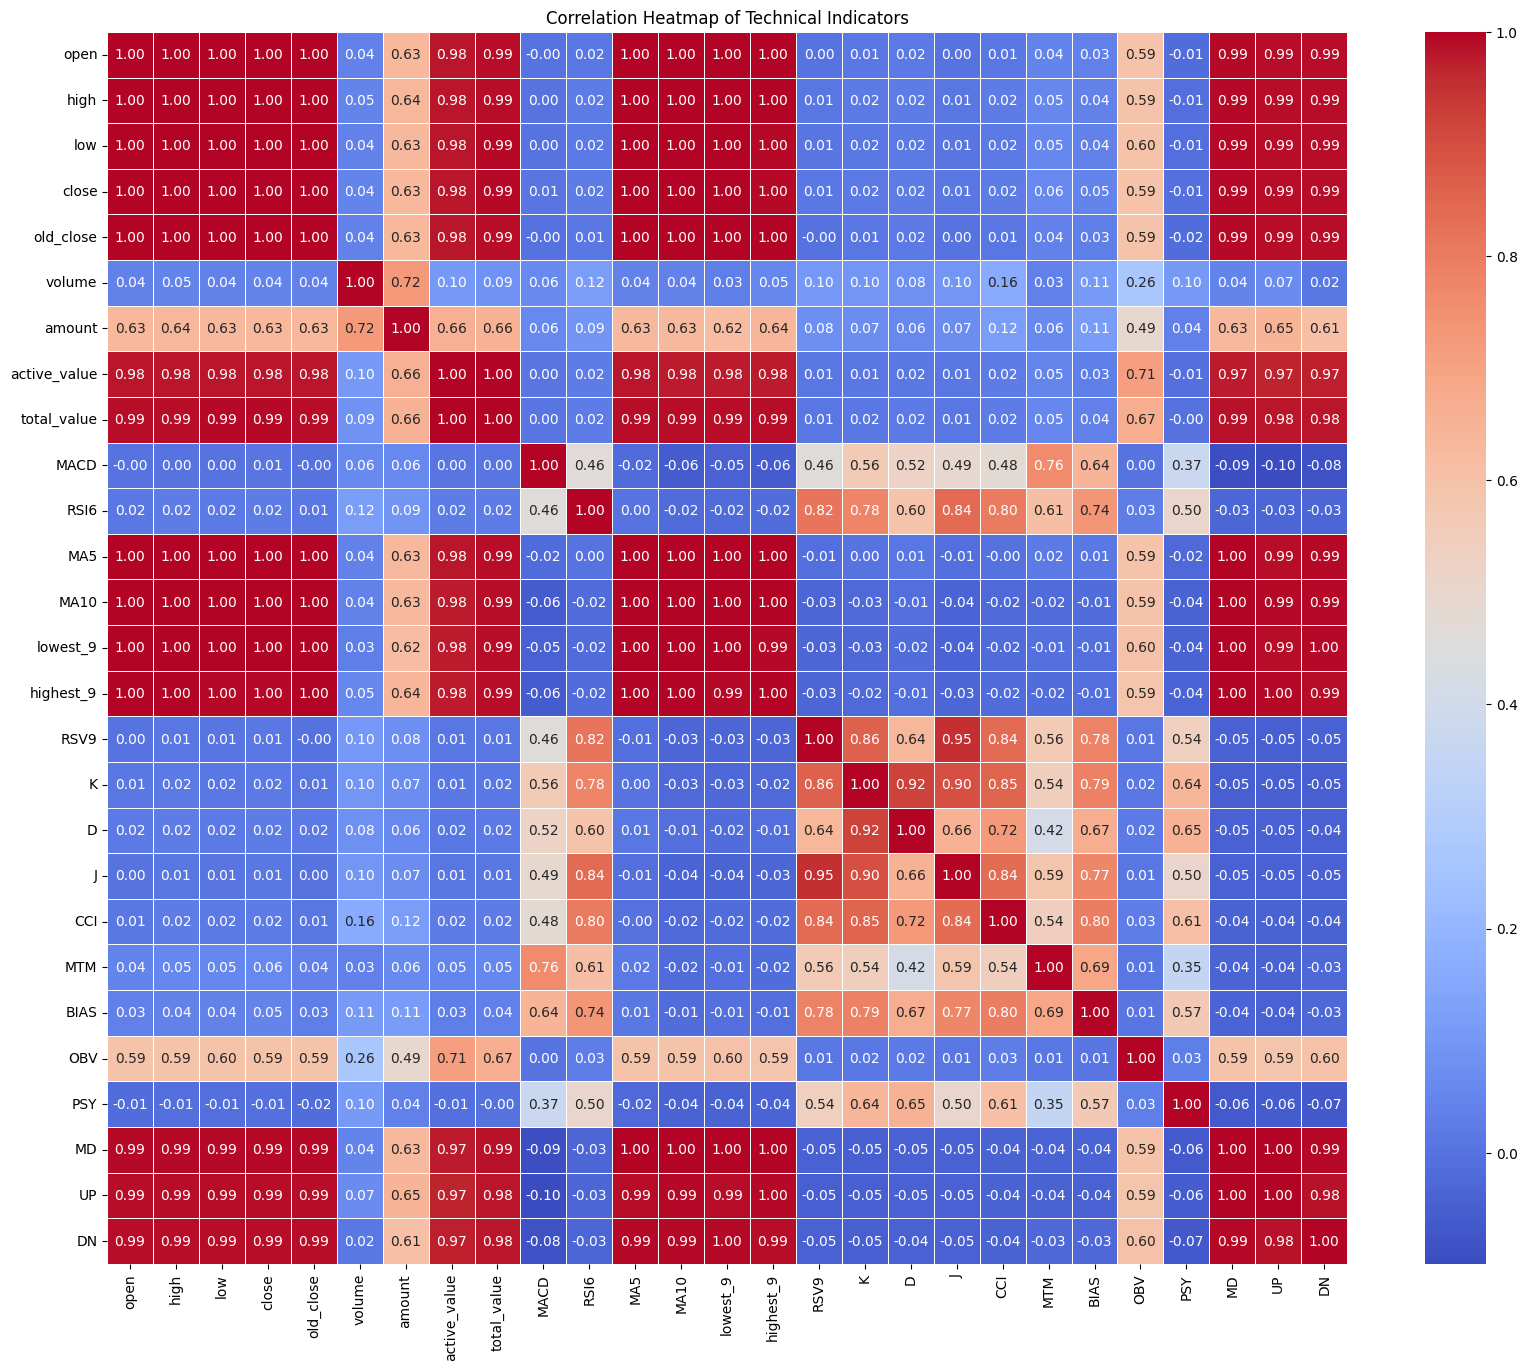

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt


# 计算各指标之间的相关系数矩阵
corr_matrix = df.corr()

# 绘制热力图
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)

# 添加标题
plt.title("Correlation Heatmap of Technical Indicators")

# 显示图表
plt.show()

## PAC主成分分析

C:\Users\Saxon\AppData\Local\Temp\ipykernel_17548\2736264009.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='PC', y='Eigenvalue', data=components_df, palette="viridis")
C:\Users\Saxon\AppData\Local\Temp\ipykernel_17548\2736264009.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='PC', y='Explained Variance Ratio (%)', data=components_df, palette="viridis")


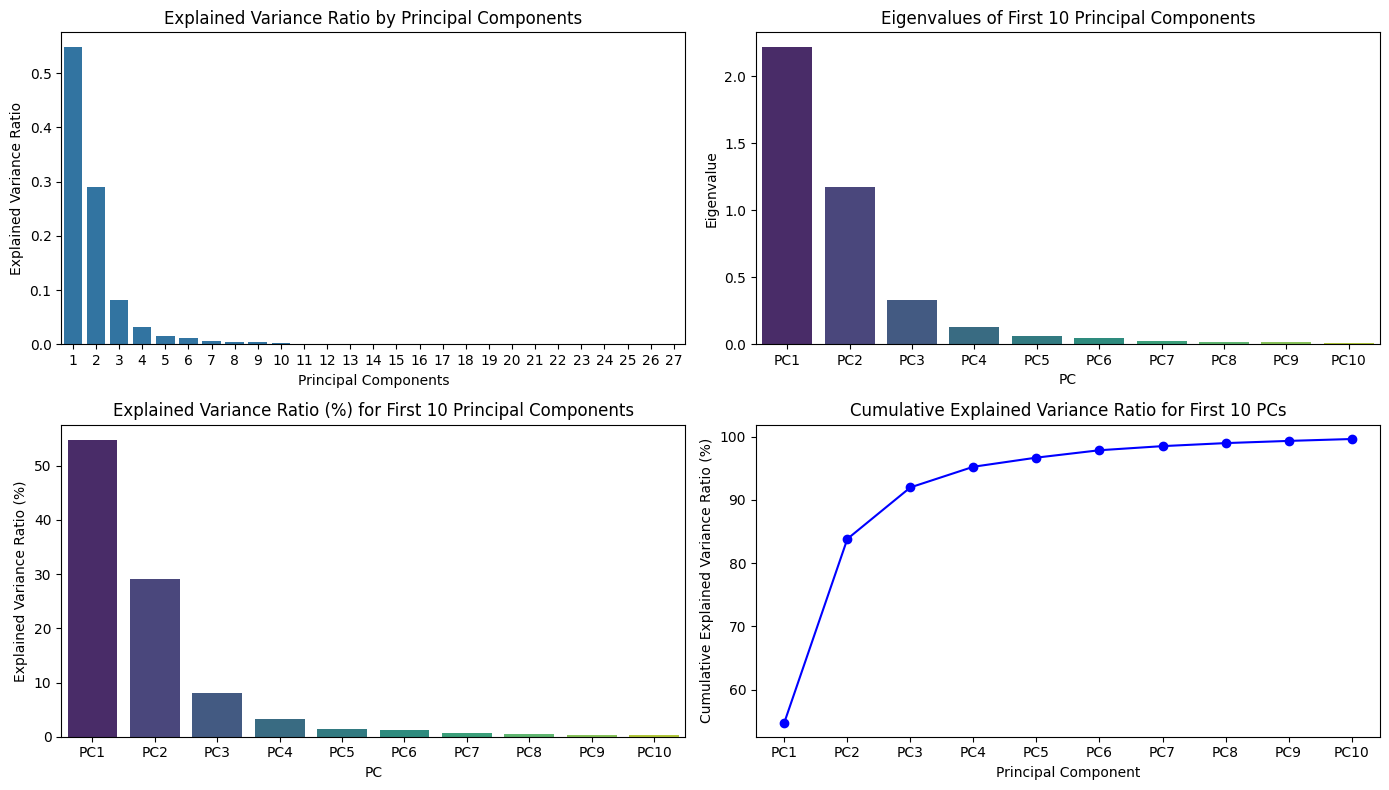

     PC  Eigenvalue  Explained Variance Ratio (%)  \
0   PC1    2.216128                     54.793864   
1   PC2    1.174873                     29.048788   
2   PC3    0.329494                      8.146764   
3   PC4    0.132129                      3.266896   
4   PC5    0.058390                      1.443707   
5   PC6    0.047221                      1.167538   
6   PC7    0.026281                      0.649806   
7   PC8    0.019380                      0.479164   
8   PC9    0.014036                      0.347030   
9  PC10    0.012132                      0.299960   

   Cumulative Explained Variance Ratio (%)  
0                                54.793864  
1                                83.842651  
2                                91.989416  
3                                95.256312  
4                                96.700019  
5                                97.867557  
6                                98.517364  
7                                98.996528  
8          

In [35]:
from sklearn.decomposition import PCA

# 执行PCA降维，保留所有主成分
pca = PCA()
pca_result = pca.fit_transform(df)

# 创建PCA结果的 DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=[f"PC{i+1}" for i in range(df.shape[1])])

# 设置图表样式
plt.figure(figsize=(14, 8))

# 可视化方差贡献，展示每个主成分的解释方差比例
plt.subplot(2, 2, 1)
sns.barplot(x=[f"{i+1}" for i in range(len(pca.explained_variance_ratio_))], y=pca.explained_variance_ratio_)
plt.title('Explained Variance Ratio by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')




# 获取特征值（Eigenvalues）和方差贡献率
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_

# 计算累计方差贡献率
cumulative_explained_variance = explained_variance_ratio.cumsum()

# 提取前10个主成分的数据
n_components = 10
components_data = {
    'PC': [f'PC{i+1}' for i in range(n_components)],
    'Eigenvalue': explained_variance[:n_components],
    'Explained Variance Ratio (%)': explained_variance_ratio[:n_components] * 100,
    'Cumulative Explained Variance Ratio (%)': cumulative_explained_variance[:n_components] * 100
}

# 创建DataFrame
components_df = pd.DataFrame(components_data)



# 绘制特征值条形图
plt.subplot(2, 2, 2)
sns.barplot(x='PC', y='Eigenvalue', data=components_df, palette="viridis")
plt.title('Eigenvalues of First 10 Principal Components')

# 绘制方差贡献率条形图
plt.subplot(2, 2, 3)
sns.barplot(x='PC', y='Explained Variance Ratio (%)', data=components_df, palette="viridis")
plt.title('Explained Variance Ratio (%) for First 10 Principal Components')

# 绘制累计方差贡献率折线图
plt.subplot(2, 2, 4)
plt.plot(components_df['PC'], components_df['Cumulative Explained Variance Ratio (%)'], marker='o', color='b')
plt.title('Cumulative Explained Variance Ratio for First 10 PCs')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance Ratio (%)')

# 适配布局并显示图形
plt.tight_layout()
plt.show()

# 输出前10主成分的数据
print(components_df)

          open          high           low         close     old_close  \
PC1   0.242446  2.413670e-01  2.406278e-01  2.415270e-01  2.416016e-01   
PC2  -0.006000 -8.088180e-03 -7.278570e-03 -9.285252e-03 -5.244681e-03   
PC3   0.111073  1.116828e-01  1.089118e-01  1.106660e-01  1.106264e-01   
PC4   0.011535  6.212901e-03  5.719996e-03  1.049032e-03  1.291472e-02   
PC5  -0.005977 -6.820291e-03 -4.726977e-03 -3.292019e-03 -5.713250e-03   
PC6  -0.006972  1.737436e-03 -9.425281e-04  7.206193e-03 -8.825359e-03   
PC7  -0.018522 -2.359147e-03 -2.612691e-02 -1.342591e-02 -1.957084e-02   
PC8  -0.065632 -7.222737e-02 -7.725142e-02 -8.165155e-02 -5.504668e-02   
PC9   0.005098 -5.336467e-03 -8.352867e-03 -1.035755e-02  1.320829e-02   
PC10 -0.012416  8.027750e-03  2.843666e-03  2.988068e-02 -1.440017e-02   
PC11 -0.000917 -4.558403e-03 -5.566767e-03 -2.555395e-03 -7.823620e-03   
PC12 -0.044333 -7.031489e-04 -1.696305e-02  2.221023e-02 -5.924583e-02   
PC13  0.075401  9.691123e-02  6.623874

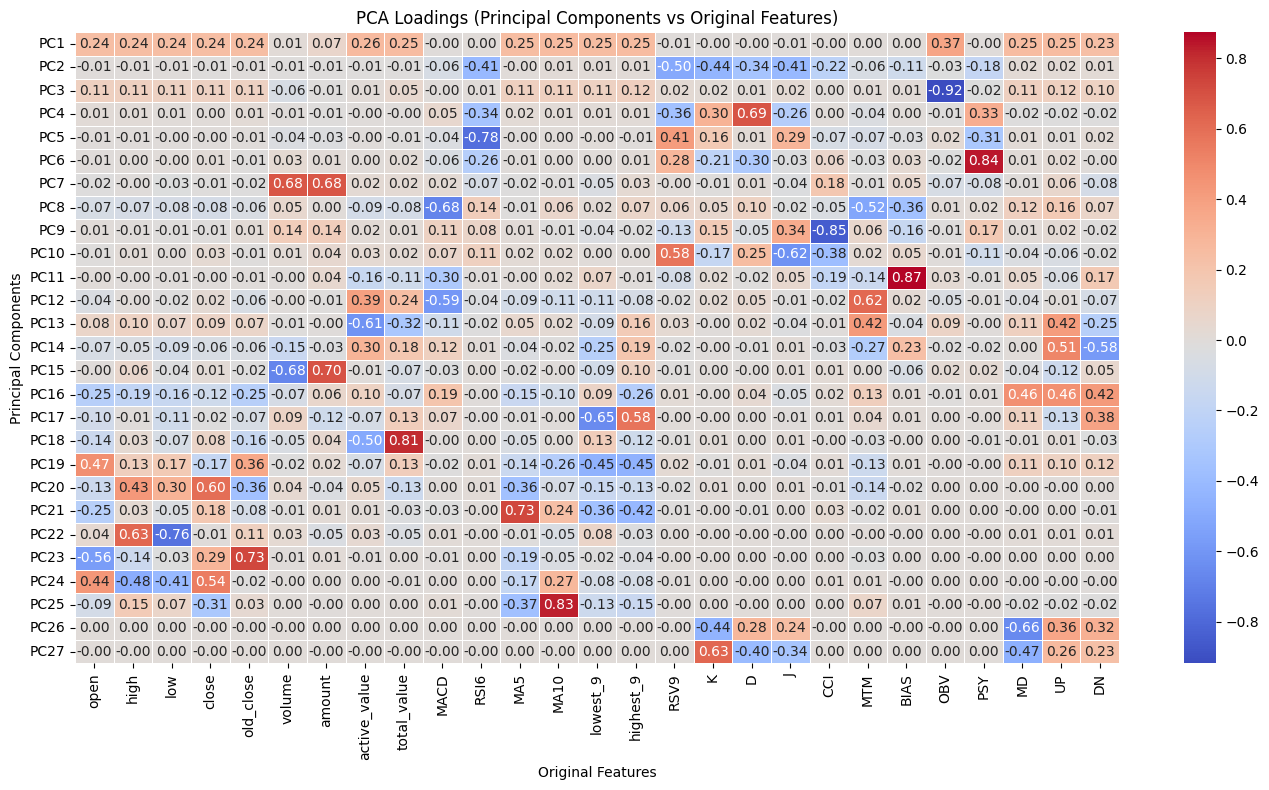

In [36]:
# 获取主成分的载荷矩阵
loadings = pca.components_

# 将载荷矩阵转换为DataFrame，方便查看和理解
loadings_df = pd.DataFrame(loadings, columns=df.columns, index=[f'PC{i+1}' for i in range(loadings.shape[0])])

# 显示载荷矩阵
print(loadings_df)

# 可视化载荷矩阵
plt.figure(figsize=(14, 8))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('PCA Loadings (Principal Components vs Original Features)')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.tight_layout()
plt.show()

## 分割训练集和测试集

In [37]:
from copy import deepcopy as dc
import torch

# 获取解释方差比例
explained_variance_ratio = pca.explained_variance_ratio_

# 获取前三个主成分（按解释方差比例选择）
top_3_components_indices = explained_variance_ratio.argsort()[-3:][::-1]  # 获取解释方差最多的3个主成分的索引

# 提取前3个主成分的数据
top_3_components = pca_result[:, top_3_components_indices]  # 选择对应的主成分列

# 创建DataFrame

X = top_3_components

y = df['close'].values


lookback = 10
num_features = 3



print(X.shape, y.shape)

split_index = int(len(X) * 0.8)

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]


# 获取 X_train 和 X_test 的大小
num_elements_train = X_train.shape[0] * X_train.shape[1]
num_elements_test = X_test.shape[0] * X_test.shape[1]

# 计算裁剪后适合 reshape 的最大元素数
train_size = (X_train.shape[0] // lookback) * lookback
test_size = (X_test.shape[0] // lookback) * lookback

X_train = X_train[:train_size]
X_test = X_test[:test_size]


y_train = y_train[:train_size]
y_test = y_test[:test_size]



# 转换为Tensor
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


(6408, 3) (6408,)


## 模型构建

In [ ]:
#导入torch库
import torch.utils.data as data
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
 
 
def train_model_no_attention(X_train, y_train, X_val, y_val):
    #定义早停机制
    class CustomEarlyStopping:
        def __init__(self, patience=10, delta=0, verbose=False):
            self.patience = patience
            self.delta = delta
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
 
        
        def __call__(self, val_loss):
            score = -val_loss
 
            if self.best_score is None:
                self.best_score = score
 
            elif score < self.best_score + self.delta:
                self.counter += 1
                if self.verbose:
                    print(f'EarlyStopping counter: {self.counter} out of {self.patience}, score: {self.best_score}')
        
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.counter = 0
 
        
    #定义神经网络模型
 
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv1d(in_channels=11, out_channels=64, kernel_size=3, padding=1)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
            self.maxpool = nn.MaxPool1d(2)
            self.lstm1 = nn.LSTM(input_size=64, hidden_size=128,batch_first=True)
            self.dropout1 = nn.Dropout(0.2)
            self.bidirectional = nn.LSTM(128, 128, bidirectional=True, batch_first=True)
            self.dropout2 = nn.Dropout(0.2)
            self.dense1 = nn.Linear(128 * 2, 64)  
            self.dense2 = nn.Linear(64, 8)
            self.dense3 = nn.Linear(8, 1)
 
        def forward(self, x):
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = self.maxpool(x.permute(0, 2, 1)) 
            x, _ = self.lstm1(x)
            x = self.dropout1(x)
            x, _ = self.bidirectional(x)
            x = x[:, -1, :]
            x = self.dropout2(x)
            x = F.sigmoid(self.dense1(x))
            x = self.dense2(x)
            x = self.dense3(x)
            return x
 
    #用来计算验证集的rmse
    def calculate_rmse(model, X, y, criterion):
        with torch.no_grad():
            y_pred = model(X.permute(0, 2, 1)).detach()
            rmse = np.sqrt(criterion(y_pred.cpu(), y.unsqueeze(1).detach()))
        return rmse
 
 
    # 创建模型实例
    Torchmodel = Net()
 
    # 定义损失函数和优化器，这类使用的是MSE损失函数和AdamW优化器
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(Torchmodel.parameters(), lr=1e-3, weight_decay=1e-5)
 
    # 定义学习率调整器
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
 
    # 将数据、模型和损失函数转移到GPU上
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    Torchmodel = Torchmodel.to(device)
    criterion = criterion.to(device)
 
 
    # 模型定义完成后，开始训练模型
    # 定义训练参数
 
    loader = data.DataLoader(data.TensorDataset(X_train, y_train),
                            batch_size = 10, shuffle = True)
 
    X_val = X_val.to(device)
 
    #创建早停机制实例
    early_stopping = CustomEarlyStopping(patience=10, verbose=True)
 
    #用来存储训练和验证损失
    train_losses = []
    val_losses = []
 
    epochs = 300
    for epoch in range(epochs):
        Torchmodel.train()
        train_loss = 0
        for X_batch, y_batch in loader:
            print(X_batch.shape)
            print(y_batch.shape)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = Torchmodel(X_batch.permute(0, 2, 1))
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()  # 累加每个batch的损失
 
        train_loss /= len(loader)  # 计算平均训练损失
        train_losses.append(np.sqrt(train_loss))  # 保存训练损失
 
        Torchmodel.eval()
        
        val_rmse = calculate_rmse(Torchmodel, X_val, y_val, criterion)
        val_losses.append(val_rmse.item())  # 保存验证损失
 
        scheduler.step(val_rmse)
        
        early_stopping(val_rmse)
        
        # 应用早停机制，确定是否停止训练
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
        if epoch % 10 == 0:
            print('*'*10, 'Epoch: ', epoch, '\ train RMSE: ', np.sqrt(train_loss), '\ val RMSE', val_rmse.item())
    
    return Torchmodel, train_losses, val_losses



Torchmodel, train_losses, val_losses= train_model_no_attention(X_train, y_train, X_test, X_test)
 
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the net

In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F

# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.maxpool = nn.MaxPool1d(2)
#         self.lstm1 = nn.LSTM(input_size=64, hidden_size=128,batch_first=True)
#         self.dropout1 = nn.Dropout(0.2)
#         self.bidirectional = nn.LSTM(128, 128, bidirectional=True, batch_first=True)
#         self.dropout2 = nn.Dropout(0.2)
#         self.dense1 = nn.Linear(128 * 2, 64)  
#         self.dense2 = nn.Linear(64, 8)
#         self.dense3 = nn.Linear(8, 1)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = self.maxpool(x.permute(0, 2, 1)) 
#         x, _ = self.lstm1(x)
#         x = self.dropout1(x)
#         x, _ = self.bidirectional(x)
#         x = x[:, -1, :]
#         x = self.dropout2(x)
#         x = F.sigmoid(self.dense1(x))
#         x = self.dense2(x)
#         x = self.dense3(x)
#         return x

In [ ]:
# import pandas as pd
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import matplotlib.pyplot as plt
# import swanlab
# from copy import deepcopy as dc
# import numpy as np
# import os
# from torch.utils.data import Dataset

# # 保存最佳模型
# def save_best_model(model, config, epoch):
#     if not os.path.exists(config.save_path):
#         os.makedirs(config.save_path)
#     torch.save(model.state_dict(), os.path.join(config.save_path, 'best_model.pth'))
#     print(f'Val Epoch: {epoch} - Best model saved at {config.save_path}')

# # 训练函数
# def train(model, X_train, y_train, optimizer, criterion, scheduler):
#     running_loss = 0
#     # 训练
#     for i in range(len(X_train)-3):
#         x_sample = X_train[i:i+3, :]
#         y_sample = y_train[i:i+3]
#         x_sample, y_sample = x_sample.to(device), y_sample.to(device)
#         print(x_sample)
#         y_pred = model(x_sample)  # 添加批量维度
        
#         loss = criterion(y_pred, y_sample.unsqueeze(0))  # 添加批量维度
#         running_loss += loss.item()
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     scheduler.step()
#     avg_loss_epoch = running_loss / len(X_train)
#     print(f'Epoch: {epoch}, Avg. Loss: {avg_loss_epoch}')
#     swanlab.log({"train/loss": running_loss}, step=epoch)

# # 验证函数
# def validate(model, config, X_test, y_test, criterion, epoch, best_loss=None):
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for i in range(len(X_test)):
#             x_sample = X_test[i]
#             y_sample = y_test[i]
#             x_sample, y_sample = x_sample.to(device), y_sample.to(device)
#             y_pred = model(x_sample)
#             loss = criterion(y_pred, y_sample)
#             val_loss += loss.item()
        
#         avg_val_loss = val_loss / len(X_test)
#         print(f'Epoch: {epoch}, Validation Loss: {avg_val_loss}')
#         swanlab.log({"val/loss": avg_val_loss}, step=epoch)
    
#     if epoch == 1:
#         best_loss = avg_val_loss
    
#     # 保存最佳模型
#     if avg_val_loss < best_loss:
#         best_loss = avg_val_loss
#         save_best_model(model, config, epoch)
    
#     return best_loss

# # 可视化预测结果
# def visualize_predictions(train_predictions, val_predictions, scaler, X_train, X_test, y_train, y_test, lookback):
#     train_predictions = train_predictions.flatten()
#     val_predictions = val_predictions.flatten()

#     dummies = np.zeros((X_train.shape[0], lookback+1))
#     dummies[:,0] = train_predictions
#     dummies = scaler.inverse_transform(dummies)
#     train_predictions = dc(dummies[:,0])

#     dummies = np.zeros((X_test.shape[0], lookback+1))
#     dummies[:,0] = val_predictions
#     dummies = scaler.inverse_transform(dummies)
#     val_predictions = dc(dummies[:,0])

#     dummies = np.zeros((X_train.shape[0], lookback+1))
#     dummies[:,0] = y_train.flatten()
#     dummies = scaler.inverse_transform(dummies)
#     new_y_train = dc(dummies[:,0])

#     dummies = np.zeros((X_test.shape[0], lookback+1))
#     dummies[:,0] = y_test.flatten()
#     dummies = scaler.inverse_transform(dummies)
#     new_y_test = dc(dummies[:,0])

#     # 训练集预测结果可视化
#     plt.figure(figsize=(10, 6))
#     plt.plot(new_y_train, color='red', label='Actual Train Close Price')
#     plt.plot(train_predictions, color='blue', label='Predicted Train Close Price', alpha=0.5)
#     plt.xlabel('Date')
#     plt.ylabel('Close Price')
#     plt.title('(TrainSet) Google Stock Price Prediction with LSTM')
#     plt.legend()

#     plt_image = []
#     plt_image.append(swanlab.Image(plt, caption="TrainSet Price Prediction"))   

#     # 测试集预测结果可视化
#     plt.figure(figsize=(10, 6))
#     plt.plot(new_y_test, color='red', label='Actual Test Close Price')
#     plt.plot(val_predictions, color='blue', label='Predicted Test Close Price', alpha=0.5)
#     plt.xlabel('Date')
#     plt.ylabel('Close Price')
#     plt.title('(TestSet) Google Stock Price Prediction with LSTM')
#     plt.legend()

#     plt_image.append(swanlab.Image(plt, caption="TestSet Price Prediction"))

#     swanlab.log({"Prediction": plt_image})

In [ ]:
# # 初始化SwanLab实验
# swanlab.login(api_key="WY1PorH8FZgejK6yyTFIV")
# swanlab.init(
#     project='Google-Stock-Prediction',
#     experiment_name="CNN-LSTM",
#     description="基于CNN-LSTM模型对Google股票价格数据集的训练与推理",
#     config={ 
#         "learning_rate": 4e-3,
#         "epochs": 50,
        
#         "lookback": 60,
#         "trainset_ratio": 0.95, 
#         "save_path": f'./checkpoint/{pd.Timestamp.now()}',
#         "optimizer": "AdamW",
#     },
# )

# config = swanlab.config
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # ------------------- 定义数据集 -------------------
# # train_dataset, test_dataset, scaler, X_train, X_test, y_train, y_test = get_stock_dataset('./GOOG.csv', config)


# # ------------------- 定义模型、超参数 -------------------
# model = Net()
# print(model)  # 打印模型结构

# model = model.to(device)
# optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)
# criterion = nn.MSELoss()

# # ------------------- 定义学习率衰减策略 -------------------
# def lr_lambda(epoch):
#     total_epochs = config.epochs
#     start_lr = config.learning_rate
#     end_lr = start_lr * 0.01
#     update_lr = ((total_epochs - epoch) / total_epochs) * (start_lr - end_lr) + end_lr
#     return update_lr * (1 / config.learning_rate)

# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# # ------------------- 训练与验证 -------------------
# for epoch in range(1, config.epochs+1):
#     model.train()
#     swanlab.log({"train/lr": scheduler.get_last_lr()[0]}, step=epoch)
#     train(model, X_train, y_train, optimizer, criterion, scheduler)
    
#     if epoch == 1: best_loss = None
#     best_loss = validate(model,config, X_test, y_test, criterion, epoch, best_loss=best_loss)
    
# # ------------------- 使用最佳模型推理，与生成可视化结果 -------------------
# with torch.no_grad():
#     # 加载最佳模型
#     best_model_path = os.path.join(config.save_path, 'best_model.pth')
#     model.load_state_dict(torch.load(best_model_path))
#     model.eval()
#     train_predictions = model(X_train.to(device)).to('cpu').numpy()
#     val_predictions = model(X_test.to(device)).to('cpu').numpy()
#     # 可视化预测结果
#     visualize_predictions(train_predictions, val_predictions, scaler, X_train, X_test, y_train, y_test, config.lookback)

swanlab: Tracking run with swanlab version 0.4.9                                   
swanlab: Run data will be saved locally in d:\xianyu\cnnlstm\code\swanlog\run-20250228_223313-b0a8d690
swanlab: 👋 Hi 2050836088, welcome to swanlab!
swanlab: Syncing run CNN-LSTM to the cloud
swanlab: 🌟 Run `swanlab watch d:\xianyu\cnnlstm\code\swanlog` to view SwanLab Experiment Dashboard locally
swanlab: 🏠 View project at https://swanlab.cn/@2050836088/Google-Stock-Prediction
swanlab: 🚀 View run at https://swanlab.cn/@2050836088/Google-Stock-Prediction/runs/f7l75u4ed7i9b4mggl4zq


Net(
  (conv1): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm1): LSTM(64, 128, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (bidirectional): LSTM(128, 128, batch_first=True, bidirectional=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (dense1): Linear(in_features=256, out_features=64, bias=True)
  (dense2): Linear(in_features=64, out_features=8, bias=True)
  (dense3): Linear(in_features=8, out_features=1, bias=True)
)
tensor([[-1.3477,  1.2556,  0.4670],
        [-1.3474,  1.6823,  0.4506],
        [-1.3571,  0.9592,  0.4684]], device='cuda:0')


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the network improves
swanlab: network error, swanlab will resume uploads when the net